## partial dependence curves

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from collections import OrderedDict

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
width = 3

def synthetic_interaction_data(n):
    df = pd.DataFrame()
    for i in range(2):
        df[f'x{i + 1}'] = np.random.random_sample(size=n) * width
    yintercept = 100
    df['y'] = df['x1']**2 + df['x2'] + yintercept
    eqn = "y = x1 * x2"
    return df, eqn

In [3]:
def friedman_partial_dependence(model,X,colname,numx=100,mean_centered=True):
    save_x = X[colname].copy()
    if numx is not None:
        uniq_x = np.linspace(start=np.min(X[colname]), stop=np.max(X[colname]), num=numx)
    else:
        uniq_x = np.unique(X[colname])
    pdpx = uniq_x
    pdpy = np.empty(shape=(len(uniq_x),))
    for i,x in enumerate(uniq_x):
        X[colname] = x
    #     print(X)
        y_pred = model.predict(X)
        pdpy[i] = y_pred.mean()
    X[colname] = save_x
    if mean_centered:
        pdpy = pdpy - np.mean(pdpy)
    return pdpx, pdpy

In [4]:
n = 200
df, eqn = synthetic_interaction_data(n)
X = df.drop('y', axis=1)
y = df['y']

In [5]:
X.head(3)

,x1,x2
0,0.025043,0.633541
1,0.047251,0.936811
2,2.442795,2.013464


In [6]:
rf = RandomForestRegressor(n_estimators=30)
_ = rf.fit(X,y)

In [7]:
pdpxs = []
pdpys = []
for i,colname in enumerate(X.columns):
    pdpx, pdpy = friedman_partial_dependence(rf,X,colname,numx=None)
    pdpxs.append(pdpx)
    pdpys.append(pdpy)

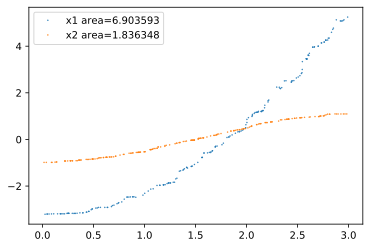

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(pdpxs[0], pdpys[0], '.', markersize=1, label=f"x1 area={np.mean(np.abs(pdpys[0]))*3:2f}")
ax.plot(pdpxs[1], pdpys[1], '.', markersize=1, label=f"x2 area={np.mean(np.abs(pdpys[1]))*3:2f}")
plt.legend()
plt.show()

## Small sample data to see PD / ICE curves

They estimate $f(z_S)$ with $E[f(z) | z_S]$

In [9]:
def f(x,y_intercept=10):
    if x.ndim==2:
        return np.array([f(row) for row in x])
    return x[0]**2 + x[1] + y_intercept

In [10]:
f(np.array([[2,2],[3,4]]))

array([16, 23])

In [11]:
df = pd.DataFrame()
df['x1'] = range(0,5)
df['x2'] = [5,1,2,4,3]
df.values

array([[0, 5],
       [1, 1],
       [2, 2],
       [3, 4],
       [4, 3]])

In [12]:
df['y'] = [f(row[1]) for row in df.iterrows()]
df

,x1,x2,y
0,0,5,15
1,1,1,12
2,2,2,16
3,3,4,23
4,4,3,29


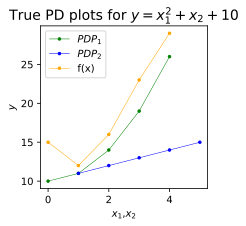

In [13]:
plt.figure(figsize=(3,3))
plt.title("True PD plots for $y = x_1^2 + x_2 + 10$", fontsize=14)
plt.plot(df['x1'], df['x1']**2+10, '.-', markersize=5, lw=.5, c='green', label="$PDP_1$")
plt.plot(df['x2'], df['x2']+10, '.-', markersize=5, lw=.5, c='blue', label="$PDP_2$")
plt.plot(df['x1'], df['x1']**2 + df['x2'] + 10, '.-', markersize=5, lw=.5, c='orange', label='f(x)')
plt.xlabel("$x_1$,$x_2$")
plt.ylabel("$y$")
plt.legend()
plt.show()

In [14]:
X = df[['x1','x2']].copy().values
X

array([[0, 5],
       [1, 1],
       [2, 2],
       [3, 4],
       [4, 3]])

In [15]:
# to compute f(x) with x_1 missing, smear x_2 column to 2nd element of x
def ICE(X,x):
    X = X.copy()
    X[:,1] = x[1]
    return f(X)

In [16]:
for i,x in enumerate(X):
    X_ = X.copy()
    X_[:,1] = x[1]
    print(f"ICE for {x}\n",X_)

ICE for [0 5]
 [[0 5]
 [1 5]
 [2 5]
 [3 5]
 [4 5]]
ICE for [1 1]
 [[0 1]
 [1 1]
 [2 1]
 [3 1]
 [4 1]]
ICE for [2 2]
 [[0 2]
 [1 2]
 [2 2]
 [3 2]
 [4 2]]
ICE for [3 4]
 [[0 4]
 [1 4]
 [2 4]
 [3 4]
 [4 4]]
ICE for [4 3]
 [[0 3]
 [1 3]
 [2 3]
 [3 3]
 [4 3]]


In [17]:
ICEs = []
shaps = []
for i,x in enumerate(X):
    ice = ICE(X,x)
    ICEs.append( ice )
    m = np.mean(ice)
    phi = f(x)-m
    shaps.append(phi)
PDP = np.mean(ICEs, axis=0)
ICEs = np.array(ICEs)
shaps = np.array(shaps)
print("ICE lines\n",ICEs)
print("avg ICE\n", np.mean(ICEs, axis=1).reshape(-1,1))
print("PDP", PDP)
print("mean(PDP)", np.mean(PDP))

ICE lines
 [[15 16 19 24 31]
 [11 12 15 20 27]
 [12 13 16 21 28]
 [14 15 18 23 30]
 [13 14 17 22 29]]
avg ICE
 [[21.]
 [17.]
 [18.]
 [20.]
 [19.]]
PDP [13. 14. 17. 22. 29.]
mean(PDP) 19.0


In [18]:
D = pd.DataFrame(ICEs, columns=[f'ICE(z={i})' for i in range(5)])
D[' '] = [f'X^({i})' for i in range(5)]
D = D.set_index(' ')
D['x_1'] = range(0,5)
D['x_2'] = range(0,5)
D['f(x)'] = f(X)
D['mean(ICE line)'] = np.mean(ICEs, axis=1)
D['phi'] = D['f(x)'] - D['mean(ICE line)']
D['phi + avg f(x)'] = D['phi'] + np.mean(D['f(x)'])
D['f(x)-avg f(X)'] = D['f(x)'] - np.mean(D['f(x)'])
#D.append(pd.Series(['foo',PDP]))
D = D[['x_1','x_2','f(x)','f(x)-avg f(X)']+[f'ICE(z={i})' for i in range(5)]+['mean(ICE line)','phi','phi + avg f(x)']]
D

,x_1,x_2,f(x),f(x)-avg f(X),ICE(z=0),ICE(z=1),ICE(z=2),ICE(z=3),ICE(z=4),mean(ICE line),phi,phi + avg f(x)
,,,,,,,,,,,,
X^(0),0,0,15,-4.0,15,16,19,24,31,21.0,-6.0,13.0
X^(1),1,1,12,-7.0,11,12,15,20,27,17.0,-5.0,14.0
X^(2),2,2,16,-3.0,12,13,16,21,28,18.0,-2.0,17.0
X^(3),3,3,23,4.0,14,15,18,23,30,20.0,3.0,22.0
X^(4),4,4,29,10.0,13,14,17,22,29,19.0,10.0,29.0


In [19]:
print("PDP = mean(ICE@i) =", PDP)
print("mean(f(x))", np.mean(D['f(x)']))
print("mean(mean(ICE lines))", np.mean(D['mean(ICE line)']))
print("mean(PDP)", np.mean(PDP))

PDP = mean(ICE@i) = [13. 14. 17. 22. 29.]
mean(f(x)) 19.0
mean(mean(ICE lines)) 19.0
mean(PDP) 19.0


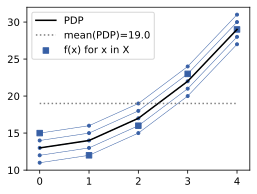

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
for i,x in enumerate(X):
    ax.plot(range(0,5), ICEs[i], '.-', c='#375FA5', lw=.5)
ax.plot(range(0,5), PDP, '-', c='k', label='PDP', markersize=10)
ax.scatter(range(0,5), D['f(x)'], marker='s', c='#375FA5', label='f(x) for x in X', s=30)
ax.plot([0,4], [np.mean(PDP)]*2, ':', c='grey', label=f'mean(PDP)={np.mean(PDP):.1f}')
ax.set_xticks([0,1,2,3,4])
ax.legend()
plt.show()

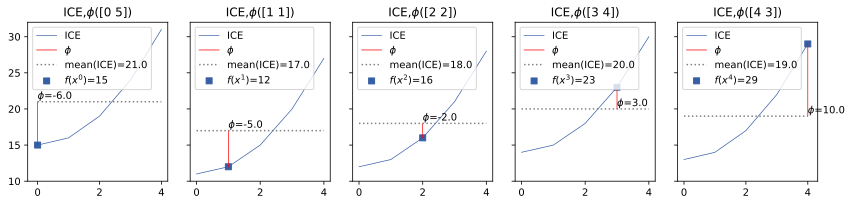

In [21]:
fig, axes = plt.subplots(1,5,figsize=(12,3),sharey=True)
for i,x in enumerate(X):
    m = np.mean(ICEs[i])
    axes[i].plot(range(0,5), ICEs[i], c='#375FA5', lw=.7, label='ICE')
    axes[i].scatter(i, f(x), marker='s', c='#375FA5', label=f"$f(x^{(i)})$={f(x)}")
    axes[i].plot([i,i],[f(x),m], c='r', lw=.7, label='$\phi$')
    axes[i].text(i,m+.4,f'$\phi$={shaps[i]:.1f}')
    axes[i].plot([0,4], [m]*2, ':', c='grey', label=f'mean(ICE)={np.mean(ICEs[i]):.1f}')
    axes[i].set_title(f"ICE,$\phi$({x})")
    axes[i].legend(loc='upper left')
plt.tight_layout()
plt.show()

[-6. -5. -2.  3. 10.] 0.0


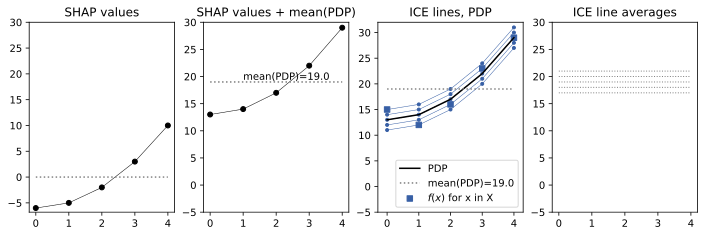

In [22]:
fig, axes = plt.subplots(1,4,figsize=(12,3.5))#, sharey=True)
print(shaps, np.mean(shaps))
axes[0].set_title("SHAP values")
axes[0].plot(range(0,5), shaps, '.-', ms=10, c='k', lw=.5)
axes[0].plot([0,4], [0,0], ':', c='grey')
axes[0].set_xticks([0,1,2,3,4])
axes[0].set_yticks([-5,0,5,10,15,20,25,30])
axes[1].set_title("SHAP values + mean(PDP)")
axes[1].plot(range(0,5), shaps + np.mean(PDP), '.-', ms=10, c='k', lw=.5)
axes[1].plot([0,4], [np.mean(PDP)]*2, ':', c='grey')
axes[1].text(1,np.mean(PDP)+.4,f'mean(PDP)={np.mean(PDP):.1f}')
axes[1].set_xticks([0,1,2,3,4])
axes[1].set_yticks([-5,0,5,10,15,20,25,30])
#axes[1].set_ylim(0,20)

for i,x in enumerate(X):
    axes[2].plot(range(0,5), ICEs[i], '.-', c='#375FA5', lw=.5)
axes[2].plot(range(0,5), PDP, '-', c='k', label='PDP', markersize=10)
axes[2].scatter(range(0,5), D['f(x)'], marker='s', c='#375FA5', label='$f(x)$ for x in X', s=30)
axes[2].plot([0,4], [np.mean(PDP)]*2, ':', c='grey', label=f'mean(PDP)={np.mean(PDP):.1f}')
axes[2].set_xticks([0,1,2,3,4])
axes[2].set_yticks([-5,0,5,10,15,20,25,30])
axes[2].legend(loc='lower right')
axes[2].set_title("ICE lines, PDP")

axes[3].plot([0,4],[D['mean(ICE line)']]*2, ':', c='grey', lw=1)
axes[3].set_xticks([0,1,2,3,4])
axes[3].set_yticks([-5,0,5,10,15,20,25,30])
axes[3].set_title("ICE line averages")

plt.show()

In [23]:
import scipy
import itertools

XX = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])
x = XX[1,:] # pick an instance
print("x =", x)
# From https://github.com/slundberg/shap/blob/master/shap/explainers/bruteforce.py
masker = lambda x, mask: x * mask + XX * np.invert(mask)
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

x = [4 5 6]


In [24]:
masker(x, [False,True,True])

array([[1, 5, 6],
       [4, 5, 6],
       [7, 5, 6]])

In [25]:
masker(x, [True,True,True])

array([[4, 5, 6],
       [4, 5, 6],
       [4, 5, 6]])

In [26]:
masker(x, [False,False,False])

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [27]:
masker(x, [False,False,True])

array([[1, 2, 6],
       [4, 5, 6],
       [7, 8, 6]])

In [28]:
p = 3
ps = powerset(set(range(p)).difference([0]))
list(ps)

[(), (1,), (2,), (1, 2)]

## Find shap means

In [29]:
def friedman_partial_dependence(model,X,colname,numx=100,mean_centered=True):
    """
    Return the partial dependence curve for y on X[colname] using all
    unique x values. For each unique x, replace entire X[colname] with
    it then compute average prediction. That is PDP for that x.
    """
    save_x = X[colname].copy()
    if numx is not None:
        uniq_x = np.random.choice(X[colname], numx)
    else:
        uniq_x = np.unique(X[colname])
    pdpx = uniq_x
    pdpy = np.empty(shape=(len(uniq_x),))
    for i,x in enumerate(uniq_x):
        X[colname] = x
    #     print(X)
        y_pred = model.predict(X)
        pdpy[i] = y_pred.mean()
    X[colname] = save_x
    if mean_centered:
        pdpy = pdpy - np.mean(pdpy)
    return pdpx, pdpy

In [147]:
import shap

def synthetic_interaction_data(n, yintercept = 10):
    df = pd.DataFrame()
    df[f'x1'] = np.random.random(size=n)*10+1
    df[f'x2'] = np.random.random(size=n)*10+1
    df['y'] = df['x1']**2 + df['x1']*df['x2'] + np.sin(df['x2']*2)*10 + yintercept
#     df['y'] = df['x1'] * df['x2'] + yintercept
    return df

# def f(x,y_intercept=10):
#     if x.ndim==2:
#         return np.array([f(row) for row in x])
#     return x[0]**2 + x[1] + y_intercept

In [148]:
df = synthetic_interaction_data(1000)
df.head(2)

,x1,x2,y
0,3.029032,5.344861,25.828888
1,7.260864,6.848413,121.491600


In [149]:
X, y = df[['x1','x2']].copy(), df['y'].copy()
X1 = X.iloc[:,0]
X2 = X.iloc[:,1]

rf = RandomForestRegressor(n_estimators=10)
rf.fit(X, y)
print("R^2 ",rf.score(X,y))

print("mean(y) =", np.mean(y))
print("mean(X_1), mean(X_2) =", np.mean(X1), np.mean(X2))

pdp_x1 = friedman_partial_dependence(rf, X, 'x1', numx=None, mean_centered=False)
pdp_x2 = friedman_partial_dependence(rf, X, 'x2', numx=None, mean_centered=False)
print("mean(PDP_1) =", np.mean(pdp_x1[1]))
print("mean(PDP_2) =", np.mean(pdp_x2[1]))

R^2  0.999345646981272
mean(y) = 91.82277955549768
mean(X_1), mean(X_2) = 6.057061076639753 5.98895273311392
mean(PDP_1) = 91.49049519418891
mean(PDP_2) = 91.4904951941889


In [150]:
explainer = shap.TreeExplainer(rf, data=shap.sample(X, 400), feature_perturbation='interventional')
shap_values = explainer.shap_values(X, check_additivity=False)
shapavg = np.mean(shap_values, axis=0)
print("SHAP avg x1,x2 =", shapavg)
shapimp = np.mean(np.abs(shap_values), axis=0)
print("SHAP avg |x1|,|x2| =", shapimp)

SHAP avg x1,x2 = [-0.82674755 -0.52813952]
SHAP avg |x1|,|x2| = [45.98071318 16.79925336]


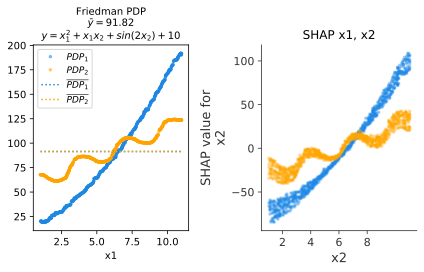

In [160]:
fig, axes = plt.subplots(1,3)

axes[0].plot(pdp_x1[0], pdp_x1[1], '.', markersize=5, c='#1E88E5', label='$PDP_1$', alpha=.5)
axes[0].plot(pdp_x2[0], pdp_x2[1], '.', markersize=5, c='orange', label='$PDP_2$', alpha=.5)
axes[0].plot([min(pdp_x1[0]),max(pdp_x1[0])], [np.mean(pdp_x1[1])]*2, ':', c='#1E88E5', label=r"$\overline{PDP_1}$")
axes[0].plot([min(pdp_x2[0]),max(pdp_x2[0])], [np.mean(pdp_x2[1])]*2, ':', c='orange', label=r"$\overline{PDP_2}$")
axes[0].set_xlabel("x1")
axes[0].set_title(f"Friedman PDP\n$\\bar{{y}}={np.mean(y):.2f}$\n$y = x_1^2 + x_1 x_2 + sin(2 x_2) + 10$", fontsize=10)
axes[0].legend(fontsize=9)

#axes[1].plot(shap_values)
shap.dependence_plot("x1", shap_values, X,
                     interaction_index=None, ax=axes[1], dot_size=10,
                     show=False, alpha=.5)
shap.dependence_plot("x2", shap_values, X,
                     interaction_index=None, ax=axes[1], dot_size=10,
                     show=False, alpha=.5, color='orange')
axes[1].set_xticks([2,4,6,8])
axes[1].set_title("SHAP x1, x2")

plot_stra
plt.tight_layout()
plt.show()